# Augustin Crepin, Marcelo Rojas

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [ ]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred, _ = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 20

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [ ]:
# Hyper-parameters 
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01

# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                    train=True, 
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),  
                    download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


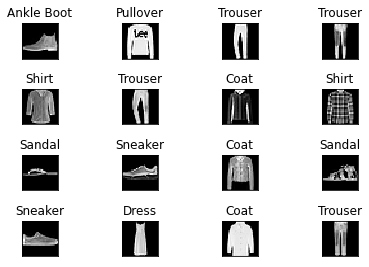

In [ ]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [ ]:
(#Pyto)rch modules
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Tamaño de capas
layers=[784,500,350,200,50,10] #4 capas ocultas

\begin{equation}
\frac{1}{1+exp(-x)}
\end{equation}

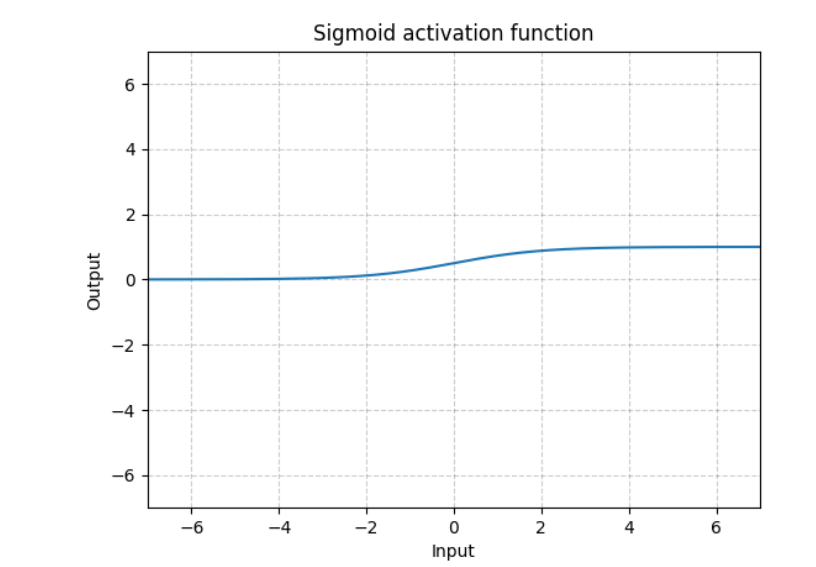


Ventajas :

*   Le da un gradiente suave mientras converge
*   Da una clara predicción (clasificación) con 1 y 0

Desvantajas :

*   No es una función centrada en el cero (siempre da valores positivos)
*   Función computacionalmente cara(de naturaleza exponencial)



In [ ]:
class NetSigmoid(nn.Module):
  def __init__(self):
    super().__init__()
    # Define aquí las capas de tu red
    self.fc1=nn.Linear(layers[0],layers[1])
    self.fc2=nn.Linear(layers[1],layers[2])
    self.fc3=nn.Linear(layers[2],layers[3])
    self.fc4=nn.Linear(layers[3],layers[4])
    self.fc5=nn.Linear(layers[4],layers[5])

  def forward(self, input):
    input = input.view(batch_size_train, -1)
    h_1 = F.sigmoid(self.fc1(input))
    h_2 = F.sigmoid(self.fc2(h_1))
    h_3 = F.sigmoid(self.fc3(h_2))
    h_4 = F.sigmoid(self.fc4(h_3))
    y_pred = self.fc5(h_4)
    
    return y_pred, h_4
    
    pass
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
  


Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetSigmoid() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.589 | Train Acc: 38.97%
	 Val. Loss: 0.876 |  Val. Acc: 68.77%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.717 | Train Acc: 72.73%
	 Val. Loss: 0.630 |  Val. Acc: 76.08%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.555 | Train Acc: 80.64%
	 Val. Loss: 0.514 |  Val. Acc: 82.36%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.462 | Train Acc: 84.46%
	 Val. Loss: 0.484 |  Val. Acc: 83.96%
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.414 | Train Acc: 85.73%
	 Val. Loss: 0.471 |  Val. Acc: 83.40%
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.400 | Train Acc: 86.11%
	 Val. Loss: 0.443 |  Val. Acc: 84.56%
Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.365 | Train Acc: 87.31%
	 Val. Loss: 0.415 |  Val. Acc: 85.50%
Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.354 | Train Acc: 87.52%
	 Val. Loss: 0.420 |  Val. Acc: 85.37%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.340 | Train Acc: 88.09%
	 Val. Loss: 0.406 |  Val. Acc: 85.70%
Epoch: 10 | Epoch T

En esta primera parte, se entrenó la red neuronal con función de activación sigmoide con una parte del conjunto de datos FashionMNIST como entrada. A continuación el objetivo será comparar el rendimiento de las diferentes funciones de activación para determinar cuál es la mejor en nuestro problema y también tratar de explicar por qué. Para esto, usaremos la misma cantidad de capas ocultas y neuronas por capa para cada una de las redes, cambiando solo la función de activación en cada caso. Se probarán diferentes números de capas y neuronas para analizar si la tendencia se mantiene.


# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre. 
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados ontenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

##Leaky Relu

\begin{equation}
\left\{
x \mbox{,  si } x \ge 0  \atop
negativeslope \cdot x  \mbox{,  si } x<0
\right.
\end{equation}

### Derivada
\begin{cases} negativeslope \mbox{, si } x<0 \\ 1 \mbox{, si } x\ge0\\ \mbox{undefined} \mbox{, si } x=0 \end{cases}

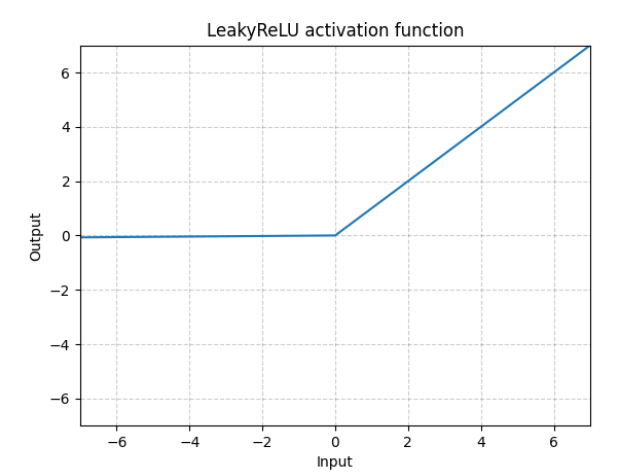

Ventajas :

*   Al igual que la ELU, evitamos el problema del relu muerto, ya que permitimos un gradiente pequeño, al calcular la derivada
*   Es más rápido de calcular que el ELU, porque no se incluye ninguna operación exponencial

Desvantajas :

*   No evita el problema del gradiente explosivo
*   La red neuronal no aprende el valor alfa
*   Se convierte en una función lineal, cuando se diferencia, mientras que la ELU es parcialmente lineal y no lineal

In [ ]:
class NetLeakyRelu(nn.Module):
  def __init__(self):
    super().__init__()
    # Define aquí las capas de tu red
    self.fc1=nn.Linear(layers[0],layers[1])
    self.fc2=nn.Linear(layers[1],layers[2])
    self.fc3=nn.Linear(layers[2],layers[3])
    self.fc4=nn.Linear(layers[3],layers[4])
    self.fc5=nn.Linear(layers[4],layers[5])

  def forward(self, input):
    input = input.view(batch_size_train, -1)
    h_1 = F.leaky_relu(self.fc1(input))
    h_2 = F.leaky_relu(self.fc2(h_1))
    h_3 = F.leaky_relu(self.fc3(h_2))
    h_4 = F.leaky_relu(self.fc4(h_3))
    y_pred = self.fc5(h_4)
    
    return y_pred, h_4
    
    pass

In [ ]:
iniciar_semillas() 
network = NetLeakyRelu()
optimizer = optim.Adam(network.parameters(), lr=learning_rate) 
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid')

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 0.873 | Train Acc: 66.96%
	 Val. Loss: 0.506 |  Val. Acc: 81.58%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.429 | Train Acc: 84.12%
	 Val. Loss: 0.421 |  Val. Acc: 85.13%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.365 | Train Acc: 86.60%
	 Val. Loss: 0.395 |  Val. Acc: 85.89%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.346 | Train Acc: 87.26%
	 Val. Loss: 0.376 |  Val. Acc: 86.69%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.315 | Train Acc: 88.28%
	 Val. Loss: 0.366 |  Val. Acc: 86.47%
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.300 | Train Acc: 88.78%
	 Val. Loss: 0.345 |  Val. Acc: 87.57%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.294 | Train Acc: 89.10%
	 Val. Loss: 0.375 |  Val. Acc: 86.66%
Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 0.273 | Train Acc: 89.95%
	 Val. Loss: 0.354 |  Val. Acc: 87.43%
Epoch: 09 | Epoch Time: 0m 14s
	Train Loss: 0.267 | Train Acc: 90.14%
	 Val. Loss: 0.342 |  Val. Acc: 88.13%
Epoch: 10 | Epoch T

##Mish

\begin{equation}
x*Tanh(Softplus(x))
\end{equation}

### Derivada
\begin{equation}
\frac{e^x(e^{3x}+4e^{2x}+(6+4x)e^{x}+4(1+x))}{((e^x+1)^2+1)^2}
\end{equation}

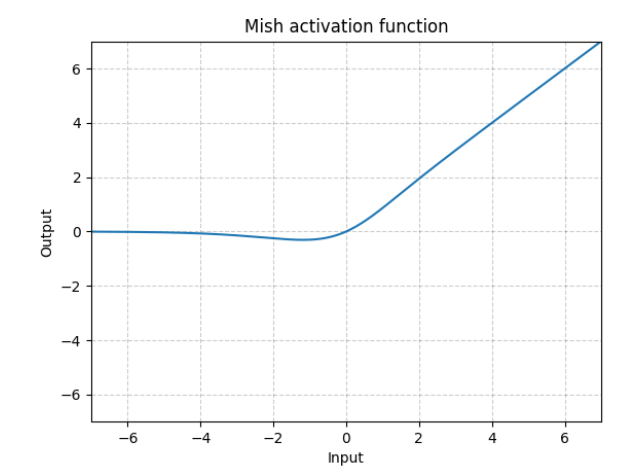

Ventajas :

*   No tiene límites por encima ya que evita la saturación que generalmente hace que el entrenamiento se ralentice drásticamente debido a los gradientes cercanos a cero
*   Estar acotado por debajo también es ventajoso porque produce fuertes efectos de regulación y reduce el sobreajuste

Desvantajas :

*   Tiempo de computacion importante debido de la complexidad de la funcion



In [ ]:
class NetMish(nn.Module):
  def __init__(self):
    super().__init__()
    # Define aquí las capas de tu red
    self.fc1=nn.Linear(layers[0],layers[1])
    self.fc2=nn.Linear(layers[1],layers[2])
    self.fc3=nn.Linear(layers[2],layers[3])
    self.fc4=nn.Linear(layers[3],layers[4])
    self.fc5=nn.Linear(layers[4],layers[5])

  def forward(self, input):
    input = input.view(batch_size_train, -1)
    h_1 = F.mish(self.fc1(input))
    h_2 = F.mish(self.fc2(h_1))
    h_3 = F.mish(self.fc3(h_2))
    h_4 = F.mish(self.fc4(h_3))
    y_pred = self.fc5(h_4)
    
    return y_pred, h_4
    
    pass

In [ ]:
iniciar_semillas() 
network = NetMish()
optimizer = optim.Adam(network.parameters(), lr=learning_rate) 
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid')

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 1.106 | Train Acc: 62.96%
	 Val. Loss: 0.521 |  Val. Acc: 81.07%
Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 0.457 | Train Acc: 83.18%
	 Val. Loss: 0.435 |  Val. Acc: 84.29%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.382 | Train Acc: 85.84%
	 Val. Loss: 0.388 |  Val. Acc: 85.80%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.347 | Train Acc: 87.27%
	 Val. Loss: 0.388 |  Val. Acc: 86.03%
Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.324 | Train Acc: 87.96%
	 Val. Loss: 0.381 |  Val. Acc: 86.31%
Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 0.308 | Train Acc: 88.61%
	 Val. Loss: 0.361 |  Val. Acc: 87.14%
Epoch: 07 | Epoch Time: 0m 17s
	Train Loss: 0.295 | Train Acc: 89.10%
	 Val. Loss: 0.368 |  Val. Acc: 87.05%
Epoch: 08 | Epoch Time: 0m 17s
	Train Loss: 0.275 | Train Acc: 89.85%
	 Val. Loss: 0.333 |  Val. Acc: 88.07%
Epoch: 09 | Epoch Time: 0m 17s
	Train Loss: 0.276 | Train Acc: 89.63%
	 Val. Loss: 0.368 |  Val. Acc: 86.95%
Epoch: 10 | Epoch T

##Elu

\begin{equation}
\left\{
\alpha(e^x-1) \mbox{ si } x \leq 0  \atop
x \mbox{ si } x>0
\right.
\end{equation}

### Derivada
\begin{cases} \alpha e^x \mbox{, si } x<0 \\ 1 \mbox{, si } x\ge0\\ \mbox{undefined} \mbox{, si } x=0 \end{cases}

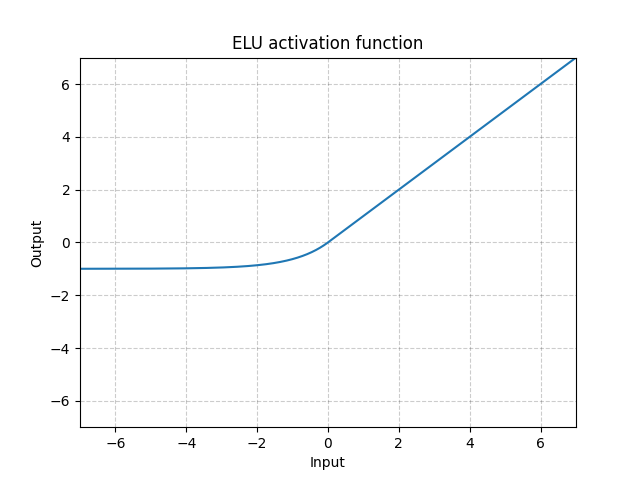

Ventajas de la funcion :


*   Produce salidas negativas, lo que ayuda a la red a empujar los pesos y los sesgos en las direcciones correctas
*   Produce activaciones en lugar de dejarlas en cero, al calcular el gradiente

Desvantajas de la funcion :
 

*   Introduce un mayor tiempo de cálculo, debido a la operación exponencial incluido
*   No evita el problema del gradiente explosivo
*   La red neuronal no aprende el valor alfa (parámetro extra)

In [ ]:
class NetElu(nn.Module):
  def __init__(self):
    super().__init__()
    # Define aquí las capas de tu red
    self.fc1=nn.Linear(layers[0],layers[1])
    self.fc2=nn.Linear(layers[1],layers[2])
    self.fc3=nn.Linear(layers[2],layers[3])
    self.fc4=nn.Linear(layers[3],layers[4])
    self.fc5=nn.Linear(layers[4],layers[5])

  def forward(self, input):
    input = input.view(batch_size_train, -1)
    h_1 = F.elu(self.fc1(input))
    h_2 = F.elu(self.fc2(h_1))
    h_3 = F.elu(self.fc3(h_2))
    h_4 = F.elu(self.fc4(h_3))
    y_pred = self.fc5(h_4)
    
    return y_pred, h_4
    
    pass

In [ ]:
iniciar_semillas() 
network = NetElu()
optimizer = optim.Adam(network.parameters(), lr=learning_rate) 
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid')

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 1.244 | Train Acc: 64.36%
	 Val. Loss: 0.539 |  Val. Acc: 80.23%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.461 | Train Acc: 83.07%
	 Val. Loss: 0.484 |  Val. Acc: 82.86%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.392 | Train Acc: 85.61%
	 Val. Loss: 0.406 |  Val. Acc: 85.47%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.359 | Train Acc: 86.85%
	 Val. Loss: 0.390 |  Val. Acc: 86.04%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.328 | Train Acc: 87.94%
	 Val. Loss: 0.358 |  Val. Acc: 86.94%
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.317 | Train Acc: 88.25%
	 Val. Loss: 0.347 |  Val. Acc: 87.54%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.297 | Train Acc: 88.98%
	 Val. Loss: 0.374 |  Val. Acc: 86.61%
Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 0.280 | Train Acc: 89.65%
	 Val. Loss: 0.348 |  Val. Acc: 87.57%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.278 | Train Acc: 89.69%
	 Val. Loss: 0.354 |  Val. Acc: 87.24%
Epoch: 10 | Epoch T

##Silu

\begin{equation}
\frac{x}{1+e^{-x}}
\end{equation}

### Derivada

\begin{equation}
\frac{1+e^{-x}+xe^{-x}}{(1+e^{-x})^2}
\end{equation}


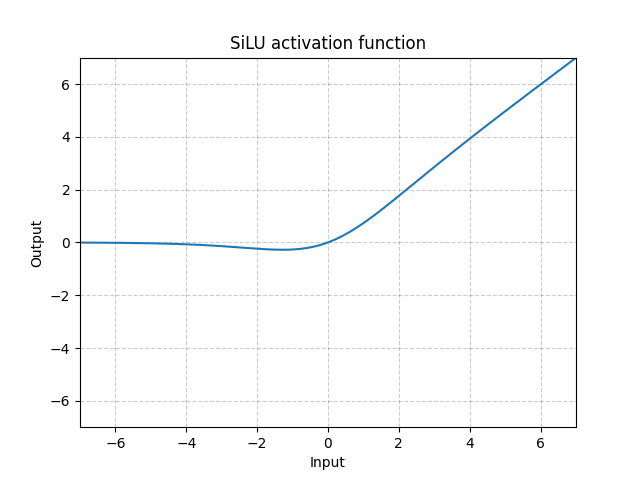

Ventajas :

*   La activación de la SiLU no es monótonamente creciente
*   El mínimo global, donde la derivada es cero, funciona como un ''piso suave'' en los pesos que sirve como un regularizador implícito que inhibe el aprendizaje de pesos de grandes magnitudes

Desvantajas :

*   Mayor tiempo de cálculo, debido a la operación exponencial incluido


In [ ]:
class NetSiLU(nn.Module):
  def __init__(self):
    super().__init__()
    # Define aquí las capas de tu red
    self.fc1=nn.Linear(layers[0],layers[1])
    self.fc2=nn.Linear(layers[1],layers[2])
    self.fc3=nn.Linear(layers[2],layers[3])
    self.fc4=nn.Linear(layers[3],layers[4])
    self.fc5=nn.Linear(layers[4],layers[5])

  def forward(self, input):
    input = input.view(batch_size_train, -1)
    h_1 = F.silu(self.fc1(input))
    h_2 = F.silu(self.fc2(h_1))
    h_3 = F.silu(self.fc3(h_2))
    h_4 = F.silu(self.fc4(h_3))
    y_pred = self.fc5(h_4)
    
    return y_pred, h_4
    
    pass

In [ ]:
iniciar_semillas() 
network = NetSiLU()
optimizer = optim.Adam(network.parameters(), lr=learning_rate) 
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid')

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 1.075 | Train Acc: 64.68%
	 Val. Loss: 0.495 |  Val. Acc: 82.00%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.442 | Train Acc: 83.95%
	 Val. Loss: 0.422 |  Val. Acc: 84.73%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.374 | Train Acc: 86.30%
	 Val. Loss: 0.386 |  Val. Acc: 85.90%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.341 | Train Acc: 87.47%
	 Val. Loss: 0.376 |  Val. Acc: 86.29%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.315 | Train Acc: 88.46%
	 Val. Loss: 0.373 |  Val. Acc: 86.43%
Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.298 | Train Acc: 89.03%
	 Val. Loss: 0.344 |  Val. Acc: 87.68%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.290 | Train Acc: 89.31%
	 Val. Loss: 0.372 |  Val. Acc: 86.95%
Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.275 | Train Acc: 89.89%
	 Val. Loss: 0.350 |  Val. Acc: 87.48%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.271 | Train Acc: 90.13%
	 Val. Loss: 0.375 |  Val. Acc: 86.45%
Epoch: 10 | Epoch T

##Accuracy para diferentes arquitecturas y capas

| Capas | Sigmoide | Leaky ReLu | Mish | ELU | SiLu |
| --- | --- | --- | --- | --- | --- |
| [784,450,10] | 88.22 | 88.01 | 88.08 | 88.32 | 88.49 |
| [784,600,10] | 87.93 | 87.86 | 87.98 | 87.69 | 87.97 |
| [784,400,200,10] | 87.93 | 88.41 | 88.07 | 88.44 | 88.37 |
| [784,450,200,10] | 88.12 | 88.47 | 88.45 | 88.58 | 88.37 |
| [784,500,200,10] | 87.87 | 88.77 | 88.50 | 88.58 | 88.37 |
| [784,600,200,10] | 87.98 | 88.35 | 88.34 | 88.75 | 88.35 |
| [784,300,200,100,10] | 88.00 | 88.34 | 88.19 | 88.54 | 88.25 |
| [784,450,200,50,10] | 87.71 | 88.67 | 88.57 | 88.70 | 88.98 |
| [784,450,200,100,10] | 87.60 | 88.34 | 88.52 | 88.53 | 88.69 |
| [784,500,300,100,10] | 87.73 | 88.47 | 88.56 | 88.39 | 88.79 |


## Comentarios

La tendencia muestra que con ELU y Silu se obtienen los mejores accuracy de test. Sin embargo, en algunas pocas configuraciones las funciones mish y leaky relu fueron mejores (en general en configuraciones con menos capas y/o neuronas.

Es importante destacar que la función sigmoide entrega mejores accuracy para redes menos complejas (menos capas y neuronas).

Las diferencias en los accuracy pueden provenir de diferentes fuentes. Por ejemplo, las funciones cuyo gradiente no tiende a cero (ya sea solo en los positivos o en los positvos y negativos a la vez), como en la función sigmoide, poseen una mayor libertad para ajustar los pesos, y por lo tanto convergen más rápido.

Primero, es posible ver que la función sigmoide es menos eficiente que todas las otras funciones, esto se debe a que las otras funciones entregan una mayor libertad para ajustar los pesos, esto pues en el lado positivo las otras funciones crecen más rápido,  por otro lado, en el lado negativo, la función sigmoide, a diferencia de las otras funciones, sigue activando la neurona positivamente. Esta es una característica que, en consecuencia,  reduce el accuracy de la red neuronal y también su eficiencia (en términos de tiempo de computo). Es importante destacar que otra razón por la que la red con función de activación sigmoide toma más tiempo, es debido a que su derivada es comparativamente más compleja de calcular.

En segundo lugar, las funciones LeakyRelu, Mish, Elu y Silu tienen resultados de accuracy similares, pero siguen existiendo algunas diferencias. Estas funciones son bastante similares en la parte positiva, pero la parte negativa es diferente para cada en términos de la pendiente (algunas son suaves que otras y alcanzan diferentes valores). También tienen expresiones analíticas diferentes lo que puede explicar el diferente tiempo de computación, pues esto puede hacer que los cálculos (como el cálculo de la derivada de la función de activación) sean más complejos.

Vemos además que para la funciones mish y Silu (junto a la función sigmooide pero de menor accuracy) tomaron un mayor tiempo de computo, lo cual se condice con sus características mencionadas (mayor tiempo de cómputo).

En base a todo esto, se puede concluir que la mejor función de activación, juntando accuracy y optimalidad, es la fnución ELU. Su rapidez en el ajuste de los pesos se debe principalmente a que su parte negativa es distinta de cero (al igual que su gradiente en la parte positiva y negativa), además, esta función es menos compleja que las funciones Mish y Silu (y similar en complejidad a la leaky relu).
 
Si bien, ELU es levemente mejor en accuracy, los resultados son más bien similares, y aqeulla similotud radica en la similitud de ambas funciones (ambas con su parte negativa, positiva y gradiente es distintos de cero).